# Final Project Submission

## Please fill out:
* Student name:
    - Carl Cook
* Student pace: 
    - Part-Time
* Scheduled project review date/time: 
    - June 10, 2020 4:30 pm
* Instructor name: 
    - James Irving
* Blog post URL:
    - https://katmandoone.github.io/apis_or_how_i_started_my_whole_project_over_again

# Introduction

In this notebook, we will be using the tmdb.org API to gather information about the film industry in recent years. Our goal is to find out what a new movie studio can do to make their first film a success. Specifically, we will look at genres, screenwriters, and associated keywords. With this information, we should be able to come up with some good ideas in regards to what kinds of films to consider and who to hire to write the screenplay.

# Questions

## Q: What genres perform the best?

- A: The genres with the highest average revenues are: Adventure, Science Fiction, Fantasy, Family, Animation, and Action. These genres are not mutually exclusive.

- Recommendation: I would recommend a Science Fiction movie, as the genre consistently earns above-average revenue. A Science Fiction film can also easily double as an Action or Adventure film, both of which are also consistently high earners.

### TMDB API

Here we use the TMDB API to gather our own information to work with. This is probably our best information source.

In [3]:
import json
import pandas as pd
import requests
import matplotlib.pyplot as plt

#### Function to supply API key

In [4]:
def get_key(path):
    with open(path) as f:
        return json.load(f)

In [5]:
key = get_key("/Users/katma/.secret/tmdb_api.json")
api_key = key["api_key"]

#### Building DataFrame

In [6]:
columns = ['id', 'title', 'revenue', 'budget', 'writer', 'director', 'genres', 'year', 'date', 'keywords']
df = pd.DataFrame(columns=columns)
years = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']

#### Filling DataFrame

This code takes a long time to run, and the resulting dataframe has been pickled below to save you the trouble.

In [ ]:
# Loops from 2010 to 2019
count = 1
for x in years:
    print('**'+x+'**')
    page = 1
    # Grabs first 10 pages from API
    while page <= 10:
        url = 'https://api.themoviedb.org/3/discover/movie?api_key=' + api_key + \
            '&language=en-US&sort_by=revenue.desc&include_adult=false&include_video=false&page=' + \
            str(page) + '&primary_release_year=' + str(x)
        by_year = requests.get(url)
        year = by_year.json()
        results = year['results']
        page += 1
        # Pulls information for each film on the current page
        for film in results:
            print(str(count)+': '+film['title'])
            count += 1
            try:
                film_rev = requests.get('https://api.themoviedb.org/3/movie/' + str(film['id']) +\
                                        '?api_key=' + api_key).json()
                crew = requests.get('https://api.themoviedb.org/3/movie/' + str(film['id']) +\
                                    '/credits?api_key=' + api_key).json()
                keywords = requests.get('https://api.themoviedb.org/3/movie/' +str(film['id']) +\
                                        '/keywords?api_key=' + api_key).json()
                details = [str(film['id']), film['title'], film_rev['revenue'], film_rev['budget'],\
                           [x['name'] for x in crew['crew'] if x['job']=='Screenplay' or (x['job']=='Writer')],\
                           [x['name'] for x in crew['crew'] if (x['job']=='Director')],\
                           [x['name'] for x in film_rev['genres']], film_rev['release_date'][:4],\
                           film_rev['release_date'][5:], [x['name'] for x in keywords['keywords']]]
                df.loc[len(df)]=details
            except:
                continue

#### Check the DataFrame

In [ ]:
# df.to_pickle('./dataframe.pkl')

In [7]:
df = pd.read_pickle('./dataframe.pkl')

In [8]:
df.head()

,id,title,revenue,budget,writer,director,genres,year,date,keywords
0,10193,Toy Story 3,1066969703,200000000,[Michael Arndt],[Lee Unkrich],"[Animation, Family, Comedy]",2010,06-16,"[hostage, college, toy, escape, daycare, teddy..."
1,12155,Alice in Wonderland,1025467110,200000000,[Linda Woolverton],[Tim Burton],"[Family, Fantasy, Adventure]",2010,03-03,"[based on novel or book, queen, fantasy world,..."
2,12444,Harry Potter and the Deathly Hallows: Part 1,954305868,250000000,[Steve Kloves],[David Yates],"[Adventure, Fantasy]",2010,10-17,"[corruption, isolation, radio, magic, teleport..."
3,27205,Inception,825532764,160000000,[Christopher Nolan],[Christopher Nolan],"[Action, Science Fiction, Adventure]",2010,07-15,"[paris, france, spy, philosophy, hotel, allego..."
4,10192,Shrek Forever After,752600867,165000000,"[Josh Klausner, Darren Lemke, Alejandro Bien-W...",[Mike Mitchell],"[Comedy, Adventure, Fantasy, Animation, Family]",2010,05-16,"[ogre, 3d]"


In [9]:
len(df.title.unique())

1991

In [10]:
df.shape

(1995, 10)

In [11]:
df.dtypes

id          object
title       object
revenue      int64
budget       int64
writer      object
director    object
genres      object
year        object
date        object
keywords    object
dtype: object

#### Convert 'budget' and 'revenue' columns to numeric data

In [12]:
df['revenue'] = pd.to_numeric(df.revenue)
df['budget'] = pd.to_numeric(df.budget)

In [13]:
df.dtypes

id          object
title       object
revenue      int64
budget       int64
writer      object
director    object
genres      object
year        object
date        object
keywords    object
dtype: object

#### Filter out films with revenue under $1M

In [14]:
df1 = df[df.revenue.gt(1000000)]

#### Explode 'genres' column so we can compare single genres

In [15]:
genre_df = df1.explode('genres')
genre_df.shape

(5132, 10)

In [16]:
genre_df.groupby(['year', 'genres']).mean().sort_values(['year', 'revenue'], ascending=False).head(20)

revenue        budget
year genres                                     
2019 Science Fiction  4.924485e+08  1.206176e+08
     Adventure        4.526650e+08  1.115556e+08
     Family           2.808875e+08  7.131111e+07
     Animation        2.312184e+08  4.958803e+07
     Action           2.176892e+08  6.214243e+07
     Fantasy          2.167856e+08  6.039139e+07
     Mystery          1.133265e+08  1.479130e+07
     Comedy           1.111112e+08  2.912083e+07
     Thriller         1.109072e+08  2.269645e+07
     Crime            1.047132e+08  2.606880e+07
     Horror           8.695294e+07  1.602273e+07
     Romance          7.874462e+07  1.698843e+07
     Drama            6.965347e+07  1.901188e+07
     War              6.822902e+07  3.057450e+07
     Music            6.388018e+07  2.335657e+07
     History          6.333776e+07  3.659754e+07
     Documentary      3.775405e+06  0.000000e+00
2018 Adventure        3.738242e+08  9.336125e+07
     Science Fiction  3.617935e+08  8.530000e+07
     Action           3.065113e+08  6.247300e+07

#### Create lists of genres for our plot

In [17]:
gen1 = ['Science Fiction', 'Adventure', 'Family']
gen2 = ['Animation', 'Action', 'Fantasy']
gen3 = ['Mystery', 'Thriller', 'Comedy']
gen4 = ['Crime', 'Horror', 'Romance']
gen5 = ['Drama', 'War', 'History']
gen6 = ['Music', 'Documentary', 'Western']

In [18]:
gen1_df = genre_df[genre_df.genres.isin(gen1)]
gen2_df = genre_df[genre_df.genres.isin(gen2)]
gen3_df = genre_df[genre_df.genres.isin(gen3)]
gen4_df = genre_df[genre_df.genres.isin(gen4)]
gen5_df = genre_df[genre_df.genres.isin(gen5)]
gen6_df = genre_df[genre_df.genres.isin(gen6)]

#### Plot average revenue by genre as compared to average revenue overall

In [19]:
genre_df.groupby('year').revenue.mean()

year
2010    1.322621e+08
2011    1.455204e+08
2012    1.557377e+08
2013    1.577144e+08
2014    1.772566e+08
2015    1.680252e+08
2016    1.898995e+08
2017    1.877622e+08
2018    1.713605e+08
2019    1.669605e+08
Name: revenue, dtype: float64

In [20]:
genre_df[genre_df['year']=='']

,id,title,revenue,budget,writer,director,genres,year,date,keywords


In [21]:
# genre_df.drop(index=404, inplace=True)

Text(0, 0.5, 'Revenue (100M)')

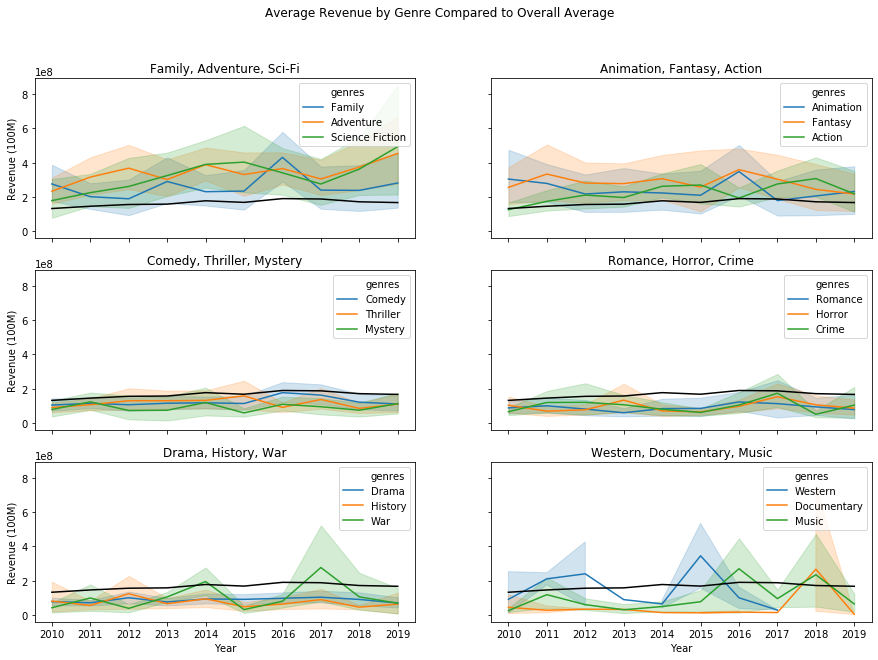

In [22]:
import seaborn as sns
fig, (ax1,ax2,ax3) = plt.subplots(3, 2, figsize=(15,10), sharex=True, sharey=True)

sns.lineplot(x='year', y='revenue', data=gen1_df, hue='genres', ax=ax1[0])
sns.lineplot(data=genre_df.groupby('year').revenue.mean(), ax=ax1[0], color='black')
ax1[0].set_title('Family, Adventure, Sci-Fi')

sns.lineplot(x='year', y='revenue', data=gen2_df, hue='genres', ax=ax1[1])
sns.lineplot(data=genre_df.groupby('year').revenue.mean(), ax=ax1[1], color='black')
ax1[1].set_title('Animation, Fantasy, Action')

sns.lineplot(x='year', y='revenue', data=gen3_df, hue='genres', ax=ax2[0])
sns.lineplot(data=genre_df.groupby('year').revenue.mean(), ax=ax2[0], color='black')
ax2[0].set_title('Comedy, Thriller, Mystery')

sns.lineplot(x='year', y='revenue', data=gen4_df, hue='genres', ax=ax2[1])
sns.lineplot(data=genre_df.groupby('year').revenue.mean(), ax=ax2[1], color='black')
ax2[1].set_title('Romance, Horror, Crime')

sns.lineplot(x='year', y='revenue', data=gen5_df, hue='genres', ax=ax3[0])
sns.lineplot(data=genre_df.groupby('year').revenue.mean(), ax=ax3[0], color='black')
ax3[0].set_title('Drama, History, War')

sns.lineplot(x='year', y='revenue', data=gen6_df, hue='genres', ax=ax3[1])
sns.lineplot(data=genre_df.groupby('year').revenue.mean(), ax=ax3[1], color='black')
ax3[1].set_title('Western, Documentary, Music')

fig.suptitle("Average Revenue by Genre Compared to Overall Average")
ax3[0].set_xlabel("Year")
ax3[1].set_xlabel("Year")
ax1[0].set_ylabel("Revenue (100M)")
ax2[0].set_ylabel("Revenue (100M)")
ax3[0].set_ylabel("Revenue (100M)")

In [23]:
genre_groups = genre_df.groupby('genres').mean().sort_values('revenue', ascending = False)
genre_groups = genre_groups[:6]

In [24]:
genre_df.revenue.mean()

165383498.01305532

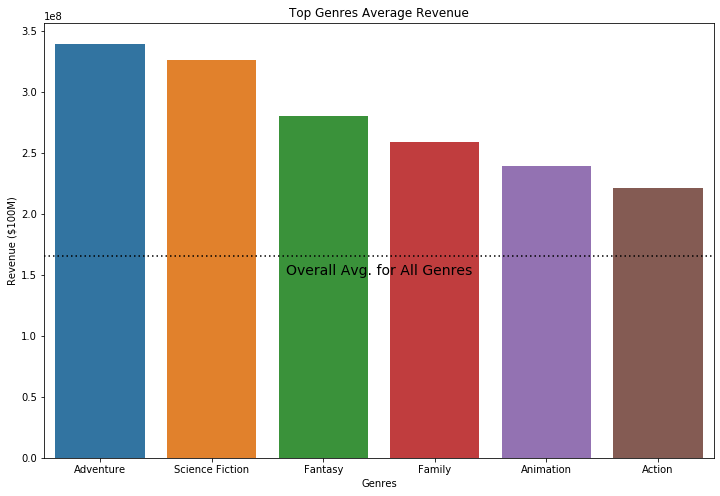

In [25]:
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.barplot(data=genre_groups[:6], x=genre_groups.index, y = 'revenue')
plt.axhline(genre_df.revenue.mean(), color='black', dashes=(1,2))
plt.text(.5, .43, 'Overall Avg. for All Genres', fontsize=14, va='center', ha='center', transform=ax.transAxes)
plt.xlabel('Genres')
plt.ylabel('Revenue ($100M)')
plt.title('Top Genres Average Revenue')
plt.savefig('overall average')

##### Here we can see that Family, Adventure, Sci-Fi, Animation, Fantasy, and Action all regularly perform better than average. Westerns, Documentaries, Music Movies, and War Movies are hit-or-miss from year-to-year, and the remaining genres regulary perform below the average.

#### Gathering information specific to 2019

In [26]:
year_19_df = genre_df[genre_df['year']=='2019'].sort_values('revenue', ascending=False)
year_19_df

,id,title,revenue,budget,writer,director,genres,year,date,keywords
1795,299534,Avengers: Endgame,2797800564,356000000,"[Christopher Markus, Stephen McFeely]","[Anthony Russo, Joe Russo]",Adventure,2019,04-24,"[space travel, time travel, time machine, sequ..."
1795,299534,Avengers: Endgame,2797800564,356000000,"[Christopher Markus, Stephen McFeely]","[Anthony Russo, Joe Russo]",Action,2019,04-24,"[space travel, time travel, time machine, sequ..."
1795,299534,Avengers: Endgame,2797800564,356000000,"[Christopher Markus, Stephen McFeely]","[Anthony Russo, Joe Russo]",Science Fiction,2019,04-24,"[space travel, time travel, time machine, sequ..."
1796,420818,The Lion King,1656943394,260000000,[Jeff Nathanson],[Jon Favreau],Adventure,2019,07-12,"[africa, lion, prince, musical, uncle, remake,..."
1796,420818,The Lion King,1656943394,260000000,[Jeff Nathanson],[Jon Favreau],Family,2019,07-12,"[africa, lion, prince, musical, uncle, remake,..."
...,...,...,...,...,...,...,...,...,...,...
1993,547590,El Chicano,1370000,0,"[Joe Carnahan, Ben Hernandez Bray]",[Ben Hernandez Bray],Crime,2019,05-03,[]
1994,608124,Chhalawa,1300000,0,[Wajahat Rauf],[Wajahat Rauf],Comedy,2019,06-05,[relationship]
1994,608124,Chhalawa,1300000,0,[Wajahat Rauf],[Wajahat Rauf],Drama,2019,06-05,[relationship]
1994,608124,Chhalawa,1300000,0,[Wajahat Rauf],[Wajahat Rauf],Family,2019,06-05,[relationship]


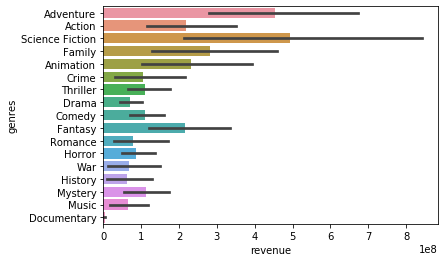

In [27]:
sns.barplot(orient='h', data=year_19_df, x='revenue', y='genres')

#### Gathering information specific to 2020

In [29]:
year_20_df = pd.DataFrame(columns=columns)
count = 1
page = 1
while page <= 10:
    url = 'https://api.themoviedb.org/3/discover/movie?api_key=' + api_key + \
      '&language=en-US&sort_by=revenue.desc&include_adult=false&include_video=false' + \
      '&primary_release_year=2020&page=' + str(page)
    year_2020 = requests.get(url)
    year_2020 = year_2020.json()
    results = year_2020['results']
    page += 1
    for film in results:
        print(str(count) + ': ' + film['title'])
        count += 1
        try:
            film_rev = requests.get('https://api.themoviedb.org/3/movie/' + str(film['id']) +\
                                    '?api_key=' + api_key + '&language=en-US').json()
            crew = requests.get('https://api.themoviedb.org/3/movie/' + str(film['id']) +
                                    '/credits?api_key=' + api_key).json()  
            keywords = requests.get('https://api.themoviedb.org/3/movie/' +str(film['id']) +\
                                    '/keywords?api_key=' + api_key).json()
            details = [str(film['id']), film['title'], film_rev['revenue'], film_rev['budget'],\
                           [x['name'] for x in crew['crew'] if x['job']=='Screenplay' or (x['job']=='Writer')],\
                           [x['name'] for x in crew['crew'] if (x['job']=='Director')],\
                           [x['name'] for x in film_rev['genres']], film_rev['release_date'][:4],\
                           film_rev['release_date'][5:], [x['name'] for x in keywords['keywords']]]
            year_20_df.loc[len(year_20_df)]=details
        except:
            continue

1: The Last Of Us Part II
2: Bad Boys for Life
3: Sonic the Hedgehog
4: Dolittle
5: Birds of Prey (and the Fantabulous Emancipation of One Harley Quinn)
6: The Invisible Man
7: The Call of the Wild
8: Onward
9: Scarlet Tulips
10: Fantasy Island
11: The Grudge
12: Underwater
13: Invasion
14: Ala Vaikunthapurramuloo
15: Bloodshot
16: Like a Boss
17: Emma.
18: Capone
19: Brahms: The Boy II
20: The Turning
21: The Way Back
22: Street Dancer 3D
23: Malang
24: UFC 246: McGregor vs. Cowboy
25: Impractical Jokers: The Movie
26: Nightlife
27: 365 Days
28: Downhill
29: The Hunt
30: My Spy
31: Varane Avashyamund
32: Lassie Come Home
33: Trolls World Tour
34: The Perfect Date
35: Block Z
36: The Elfkins - Baking a Difference
37: Sudakshinar Saree
38: I Love You, Stupid
39: ALL COPS AIN'T BAD
40: Trump 2020 Tulsa Campaign Rally
41: Funhouse
42: Mortal
43: Maceracı Yüzgeçler: Büyük Gösteri
44: The Mafia: Payback
45: Enter the Fat Dragon
46: Unsubscribe
47: Permette? Alberto Sordi
48: Boundary
49: To

In [30]:
year_20_df

,id,title,revenue,budget,writer,director,genres,year,date,keywords
0,38700,Bad Boys for Life,419074646,90000000,"[Joe Carnahan, Peter Craig, Chris Bremner]","[Adil El Arbi, Bilall Fallah]","[Thriller, Action, Crime]",2020,01-15,"[detective, sequel, police officer, police det..."
1,454626,Sonic the Hedgehog,306766470,85000000,"[Josh Miller, Patrick Casey]",[Jeff Fowler],"[Action, Science Fiction, Comedy, Family]",2020,02-12,"[video game, san francisco, california, friend..."
2,448119,Dolittle,223343452,175000000,"[Stephen Gaghan, Chris McKay, Thomas Shepherd]",[Stephen Gaghan],"[Comedy, Fantasy, Adventure, Family]",2020,01-01,"[based on novel or book, island, ship, victori..."
3,495764,Birds of Prey (and the Fantabulous Emancipatio...,201858461,75000000,[Christina Hodson],[Cathy Yan],"[Action, Crime, Comedy]",2020,02-05,"[dc comics, based on comic, woman director, dc..."
4,570670,The Invisible Man,123414678,9000000,[Leigh Whannell],[Leigh Whannell],"[Thriller, Science Fiction, Horror]",2020,02-26,"[based on novel or book, architect, pregnancy,..."
...,...,...,...,...,...,...,...,...,...,...
194,717249,Qu'est-ce qui fait courir Darry Cowl ?,0,0,[],[Sonia Medina],[Documentary],2020,06-13,[]
195,717238,Clasher l'ennui,0,0,[],[Yveline Ruaud],[Documentary],2020,06-19,[rap music]
196,717224,Junior,0,0,[],[],[Documentary],2020,06-21,[]
197,717223,99¢ Dreams,0,0,[Tasnim Boufelfel],[Tasnim Boufelfel],[Drama],2020,06-16,[]


In [31]:
DF = pd.concat([df, year_20_df])

In [32]:
DF

,id,title,revenue,budget,writer,director,genres,year,date,keywords
0,10193,Toy Story 3,1066969703,200000000,[Michael Arndt],[Lee Unkrich],"[Animation, Family, Comedy]",2010,06-16,"[hostage, college, toy, escape, daycare, teddy..."
1,12155,Alice in Wonderland,1025467110,200000000,[Linda Woolverton],[Tim Burton],"[Family, Fantasy, Adventure]",2010,03-03,"[based on novel or book, queen, fantasy world,..."
2,12444,Harry Potter and the Deathly Hallows: Part 1,954305868,250000000,[Steve Kloves],[David Yates],"[Adventure, Fantasy]",2010,10-17,"[corruption, isolation, radio, magic, teleport..."
3,27205,Inception,825532764,160000000,[Christopher Nolan],[Christopher Nolan],"[Action, Science Fiction, Adventure]",2010,07-15,"[paris, france, spy, philosophy, hotel, allego..."
4,10192,Shrek Forever After,752600867,165000000,"[Josh Klausner, Darren Lemke, Alejandro Bien-W...",[Mike Mitchell],"[Comedy, Adventure, Fantasy, Animation, Family]",2010,05-16,"[ogre, 3d]"
...,...,...,...,...,...,...,...,...,...,...
194,717249,Qu'est-ce qui fait courir Darry Cowl ?,0,0,[],[Sonia Medina],[Documentary],2020,06-13,[]
195,717238,Clasher l'ennui,0,0,[],[Yveline Ruaud],[Documentary],2020,06-19,[rap music]
196,717224,Junior,0,0,[],[],[Documentary],2020,06-21,[]
197,717223,99¢ Dreams,0,0,[Tasnim Boufelfel],[Tasnim Boufelfel],[Drama],2020,06-16,[]


In [33]:
plot_df = DF.loc[(DF.year=='2019')|(DF.year=='2020')]

In [34]:
plot_df = plot_df.explode('genres')

In [35]:
plot_df = plot_df[plot_df.revenue.gt(1000000)]

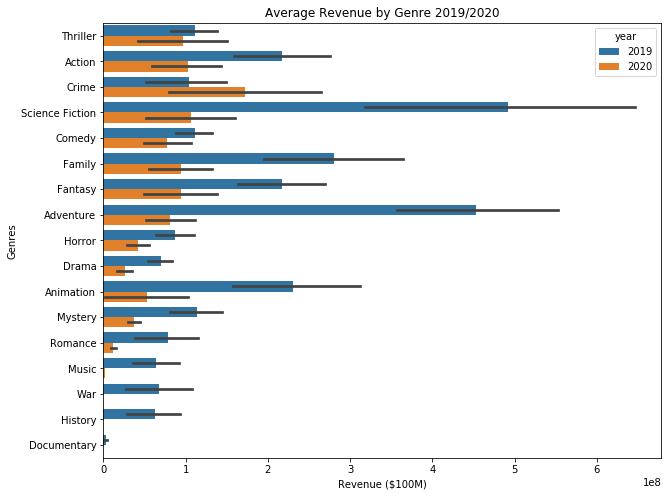

In [36]:
fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(orient='h', data=plot_df, x='revenue', y='genres', hue='year', ci=68)
plt.title('Average Revenue by Genre 2019/2020')
plt.ylabel('Genres')
plt.xlabel('Revenue ($100M)')
plt.savefig('2019 2020')

In [37]:
year_20_df.dtypes

id          object
title       object
revenue     object
budget      object
writer      object
director    object
genres      object
year        object
date        object
keywords    object
dtype: object

#### Make 'budget' and 'revenue' numeric again

In [38]:
year_20_df['revenue'] = pd.to_numeric(year_20_df.revenue)
year_20_df['budget'] = pd.to_numeric(year_20_df.budget)

In [39]:
year_20_df.dtypes

id          object
title       object
revenue      int64
budget       int64
writer      object
director    object
genres      object
year        object
date        object
keywords    object
dtype: object

#### Only use films with revenue over 1M to keep data comparable to previous years

In [40]:
year_20_df = year_20_df[year_20_df.revenue.gt(1000000)]

In [41]:
year_20_df = year_20_df.explode('genres')

In [42]:
year_20_df

,id,title,revenue,budget,writer,director,genres,year,date,keywords
0,38700,Bad Boys for Life,419074646,90000000,"[Joe Carnahan, Peter Craig, Chris Bremner]","[Adil El Arbi, Bilall Fallah]",Thriller,2020,01-15,"[detective, sequel, police officer, police det..."
0,38700,Bad Boys for Life,419074646,90000000,"[Joe Carnahan, Peter Craig, Chris Bremner]","[Adil El Arbi, Bilall Fallah]",Action,2020,01-15,"[detective, sequel, police officer, police det..."
0,38700,Bad Boys for Life,419074646,90000000,"[Joe Carnahan, Peter Craig, Chris Bremner]","[Adil El Arbi, Bilall Fallah]",Crime,2020,01-15,"[detective, sequel, police officer, police det..."
1,454626,Sonic the Hedgehog,306766470,85000000,"[Josh Miller, Patrick Casey]",[Jeff Fowler],Action,2020,02-12,"[video game, san francisco, california, friend..."
1,454626,Sonic the Hedgehog,306766470,85000000,"[Josh Miller, Patrick Casey]",[Jeff Fowler],Science Fiction,2020,02-12,"[video game, san francisco, california, friend..."
...,...,...,...,...,...,...,...,...,...,...
31,446893,Trolls World Tour,1946164,0,"[Wallace Wolodarsky, Glenn Berger, Jonathan Ai...",[Walt Dohrn],Family,2020,03-12,"[sequel, based on toy]"
31,446893,Trolls World Tour,1946164,0,"[Wallace Wolodarsky, Glenn Berger, Jonathan Ai...",[Walt Dohrn],Comedy,2020,03-12,"[sequel, based on toy]"
31,446893,Trolls World Tour,1946164,0,"[Wallace Wolodarsky, Glenn Berger, Jonathan Ai...",[Walt Dohrn],Fantasy,2020,03-12,"[sequel, based on toy]"
31,446893,Trolls World Tour,1946164,0,"[Wallace Wolodarsky, Glenn Berger, Jonathan Ai...",[Walt Dohrn],Adventure,2020,03-12,"[sequel, based on toy]"


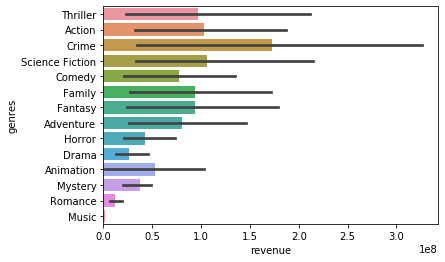

In [43]:
sns.barplot(orient='h', data=year_20_df, x='revenue', y='genres')

#### Plot to compare average revenue by genre from 2019 to 2020 so far

Text(0.5, 0.98, 'Average Revenues by Genre in 2019, 2020')

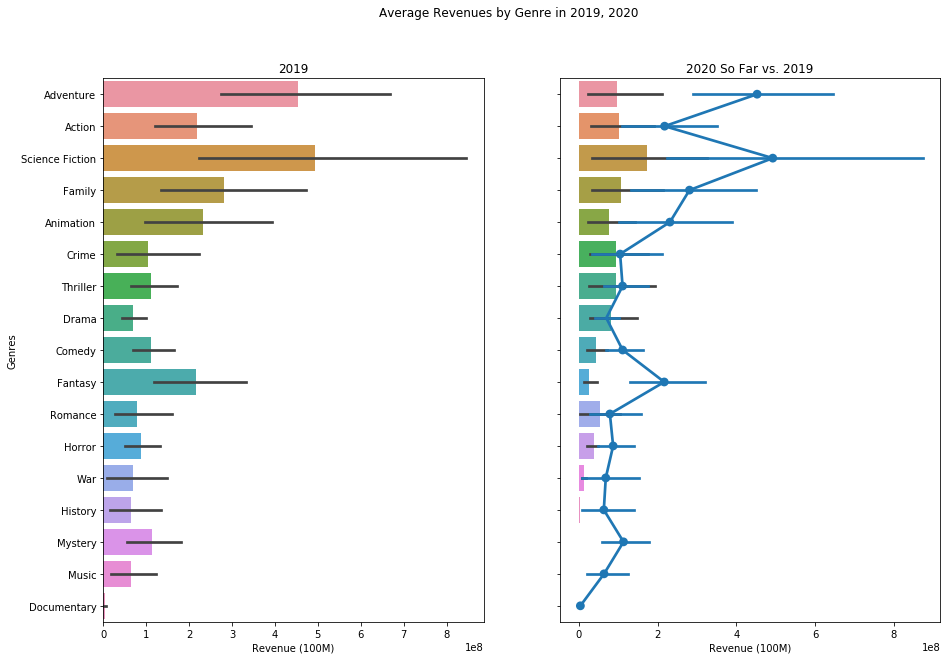

In [44]:
fig, ax1 = plt.subplots(1, 2, figsize=(15,10), sharey=True)
sns.barplot(orient='h', data=year_19_df, x='revenue', y='genres', ax=ax1[0])
ax1[0].set_title("2019")
ax1[0].set_xlabel("Revenue (100M)")
ax1[0].set_ylabel('Genres')
sns.barplot(orient='h', data=year_20_df, x='revenue', y='genres', ax=ax1[1])
sns.pointplot(data=year_19_df, x='revenue', y='genres', ax=ax1[1])
ax1[1].set_title('2020 So Far vs. 2019')
ax1[1].set_xlabel('Revenue (100M)')
ax1[1].set_ylabel("")
fig.suptitle("Average Revenues by Genre in 2019, 2020")

## Q: Who are the top writers for the top genres, and how much revenue do their movies pull?

- A: The screenwriter may have a significant effect on a film's performance. Even as far down as #30 in the list, these writers' films are outperforming the overall average by a factor of 4.

- Recommendation: Hire writers from this list, especially those who have had success with similar films.

In [47]:
best_genres_df = genre_df[(genre_df.genres.isin(gen1))|(genre_df.genres.isin(gen2))]
best_genres_df.sort_values('revenue', ascending=False).head()

,id,title,revenue,budget,writer,director,genres,year,date,keywords
1795,299534,Avengers: Endgame,2797800564,356000000,"[Christopher Markus, Stephen McFeely]","[Anthony Russo, Joe Russo]",Adventure,2019,04-24,"[space travel, time travel, time machine, sequ..."
1795,299534,Avengers: Endgame,2797800564,356000000,"[Christopher Markus, Stephen McFeely]","[Anthony Russo, Joe Russo]",Science Fiction,2019,04-24,"[space travel, time travel, time machine, sequ..."
1795,299534,Avengers: Endgame,2797800564,356000000,"[Christopher Markus, Stephen McFeely]","[Anthony Russo, Joe Russo]",Action,2019,04-24,"[space travel, time travel, time machine, sequ..."
997,140607,Star Wars: The Force Awakens,2068223624,245000000,"[Lawrence Kasdan, Michael Arndt, J.J. Abrams]",[J.J. Abrams],Fantasy,2015,12-15,"[android, spacecraft, jedi, imax, space opera,..."
997,140607,Star Wars: The Force Awakens,2068223624,245000000,"[Lawrence Kasdan, Michael Arndt, J.J. Abrams]",[J.J. Abrams],Science Fiction,2015,12-15,"[android, spacecraft, jedi, imax, space opera,..."


In [84]:
writers_df = best_genres_df.drop(columns=['genres', 'director', 'keywords'])

In [85]:
writers_df = writers_df.explode('writer')
writers_df = writers_df.drop_duplicates()

In [86]:
writers_df.duplicated().sum()

0

In [87]:
writers_plot = writers_df.groupby(['writer']).mean().sort_values(['revenue'], ascending=False).head(30)

Text(0, 0.5, '')

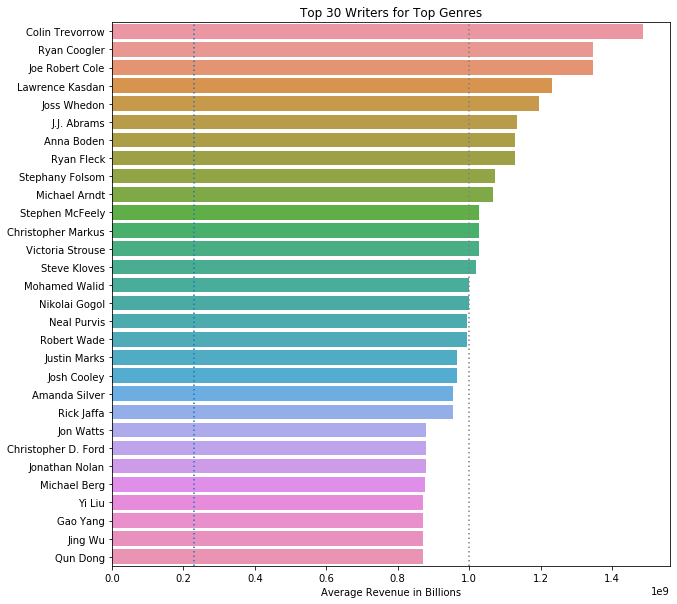

In [88]:
fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(data=writers_plot, x='revenue', y=writers_plot.index, orient='h', ax=ax)
plt.axvline(x=writers_df.revenue.mean(), dashes=(1,2))
plt.axvline(x=1000000000, c='grey', dashes=(1,2))
plt.title('Top 30 Writers for Top Genres')
plt.xlabel('Average Revenue in Billions')
plt.ylabel('')

## What keywords describe the best-performing movies?

- A: Many popular movies are based on other popular media. Movies featuring dystopian futures, magic, aliens, the battle of good and evil, and superpowers are quite popular.

- Recommendation: I would recommend making a movie based on an existing book series, whether that be a series of novels or a series of comics. Basing a film on a series opens up the door for future sequels, which is #3 on the list of top keywords. Many of the top keywords (dystopia, alien, spacecraft, robot, etc.) lend themselves well to Science Fiction pictures.

In [89]:
keywords_df = best_genres_df.drop(columns=['writer', 'director', 'genres'])
keywords_df.head()

,id,title,revenue,budget,year,date,keywords
0,10193,Toy Story 3,1066969703,200000000,2010,06-16,"[hostage, college, toy, escape, daycare, teddy..."
0,10193,Toy Story 3,1066969703,200000000,2010,06-16,"[hostage, college, toy, escape, daycare, teddy..."
1,12155,Alice in Wonderland,1025467110,200000000,2010,03-03,"[based on novel or book, queen, fantasy world,..."
1,12155,Alice in Wonderland,1025467110,200000000,2010,03-03,"[based on novel or book, queen, fantasy world,..."
1,12155,Alice in Wonderland,1025467110,200000000,2010,03-03,"[based on novel or book, queen, fantasy world,..."


In [90]:
keywords_df = keywords_df.explode('keywords')

In [91]:
keywords_df = keywords_df.drop_duplicates()

In [92]:
keywords_df = keywords_df.dropna()
len(keywords_df)

7797

In [93]:
keywords_df = keywords_df[keywords_df.revenue.gt(df.revenue.mean())]
len(keywords_df)

3850

In [94]:
keywords_plot = keywords_df.keywords.value_counts()[:30]
keywords_plot

duringcreditsstinger          72
3d                            69
sequel                        69
aftercreditsstinger           53
based on comic                52
based on novel or book        46
superhero                     45
dystopia                      36
based on young adult novel    25
magic                         23
marvel cinematic universe     22
anthropomorphism              21
super power                   20
alien                         18
remake                        17
imax                          17
spacecraft                    16
good vs evil                  16
spy                           14
friendship                    14
robot                         14
future                        14
new york city                 14
revenge                       13
space                         13
family                        12
musical                       11
alien invasion                11
london, england               11
based on video game           11
Name: keyw

In [95]:
keywords_plot = pd.DataFrame(keywords_plot).reset_index()

In [96]:
keywords_plot

,index,keywords
0,duringcreditsstinger,72
1,3d,69
2,sequel,69
3,aftercreditsstinger,53
4,based on comic,52
5,based on novel or book,46
6,superhero,45
7,dystopia,36
8,based on young adult novel,25
9,magic,23


Text(0, 0.5, 'Keywords')

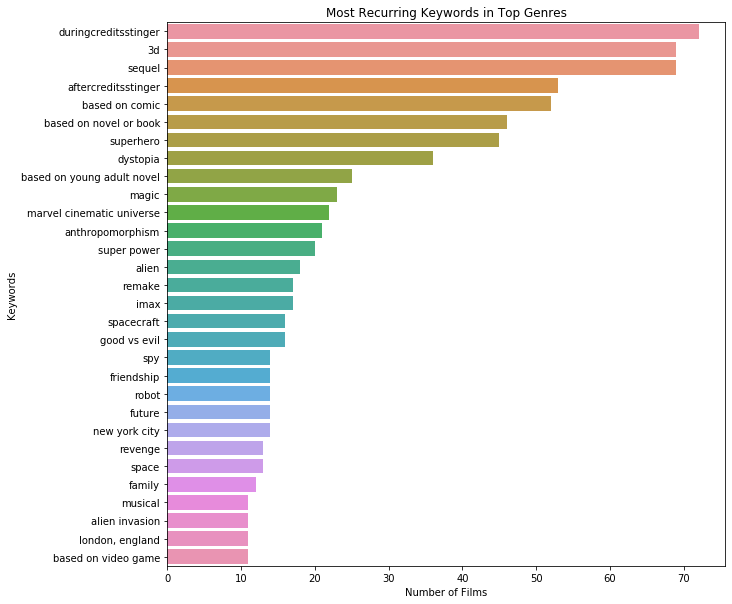

In [97]:
fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(data=keywords_plot, orient='h', x='keywords', y='index', ax=ax)
plt.title('Most Recurring Keywords in Top Genres')
plt.xlabel('Number of Films')
plt.ylabel('Keywords')

##### Obviously, there are some here that we can't use, like 'sequel' or 'marvel cinematic universe.' It stands to reason, though, that a movie left open for a sequel is a good investment. Also, movies based on books and comics seem to do well.

## What is the effect of release date on expected revenue?

In [ ]:
df.head()

#### Getting the month from the date column

In [ ]:
df['month'] = [[x][0][:2] for x in df['date']]
df.head()

#### Using month to determine quarter

In [ ]:
import math
df['quarter'] = [math.ceil(int(x)/3) for x in df['month']]
df

#### Plot by quarter for 2010-2019

In [ ]:
sns.lineplot(data=df, x='year', y='revenue', hue='quarter', palette='Dark2')

#### find release quarters for 2020

In [ ]:
year_20_df['month'] = [[x][0][:2] for x in year_20_df['date']]
year_20_df['quarter'] = [math.ceil(int(x)/3) for x in year_20_df['month']]
year_20_df.groupby('quarter').count()

#### Plot 2020 by month since there are only 2 quarters to show

In [ ]:
sns.lineplot(data=year_20_df, x='month', y='revenue')

#### Show plot comparing past years quarterly to this year

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15,5), sharey=True)
sns.lineplot(data=df, x='year', y='revenue', hue='quarter', palette='Dark2', ax=axes[0])
sns.lineplot(data=year_20_df, x='month', y='revenue', ax=axes[1])
axes[0].set_title('Revenue by Quarter 2010-2019')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Revenue (100M)')
axes[1].set_title('Revenue by Month 2020')
axes[1].set_xlabel('Month')
fig.suptitle("A Comparison of Revenue by Release Schedule")

##### Here we can see that we can expect a bump in revenue in quarters 2 and 4. So, the best time to release our film is in the summer or during the holiday season. 2020 has not gotten its quarter 2 bump, presumably due to Covid-19 restrictions.

## Recommendation: Big budget Sci-Fi/Adventure film to (based on popular book or comic series) release in summer or the holiday season. Revenues are currently below expectations due to Covid-19, but we can expect that slump to be over before the film finishes production. Starting a film franchise is a good investment for revenue in the future.